In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
epsilons = [0, .05, .1, .15, .2, .25, .3] #for MNIST

pretrained_model = "/content/drive/MyDrive/lenet_mnist_model.pth"
use_cuda=True
# Set random seed for reproducibility
torch.manual_seed(42)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# LeNet Model definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

#transforms.Normalize((0.1307,), (0.3081,)),
# MNIST Test dataset and dataloader declaration
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor()
            ])),
        batch_size=128, shuffle=True)

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True, transform=transforms.Compose([
            transforms.ToTensor()
            ])),
        batch_size=128, shuffle=True)

# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if use_cuda and torch.cuda.is_available() else "cpu")

# Initialize the network
model = Net().to(device)

# Load the pretrained model
model.load_state_dict(torch.load(pretrained_model, map_location=device))

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

CUDA Available:  True


Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [ ]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

def normalize(X, mu = 0.1307, std = 0.3081):
  return X #(X - mu)/std

def pgd_attack(model, X, y, epsilon, alpha, attack_iters, norm, device):

  upper_limit, lower_limit = 1,0
  delta = torch.zeros_like(X).to(device)
  if norm == "l_inf":
    delta.uniform_(-epsilon, epsilon)
  elif norm == "l_2":
    delta.normal_()
    d_flat = delta.view(delta.size(0),-1)
    n = d_flat.norm(p=2,dim=1).view(delta.size(0),1,1,1)
    r = torch.zeros_like(n).uniform_(0, 1)
    delta *= 1/n * r * epsilon
  else:
    raise ValueError
  delta = torch.clamp(delta, lower_limit-X, upper_limit-X)
  delta.requires_grad = True

  for _ in range(attack_iters):
      output = model(normalize(X + delta))

      loss = F.cross_entropy(output, y)
      loss.backward()

      grad = delta.grad.detach()

      d = delta
      g = grad
      x = X

      if norm == "l_inf":
          d = torch.clamp(d + alpha * torch.sign(g), min=-epsilon, max=epsilon)
      elif norm == "l_2":
          g_norm = torch.norm(g.view(g.shape[0],-1),dim=1).view(-1,1,1,1)
          scaled_g = g/(g_norm + 1e-10)
          d = (d + scaled_g*alpha).view(d.size(0),-1).renorm(p=2,dim=0,maxnorm=epsilon).view_as(d)

      d = torch.clamp(d, lower_limit - x, upper_limit - x)

      delta.data = d
      delta.grad.zero_()
  return X+delta

# restores the tensors to their original scale
def denorm(batch, mean=[0.1307], std=[0.3081]):
    """
    Convert a batch of tensors to their original scale.

    Args:
        batch (torch.Tensor): Batch of normalized tensors.
        mean (torch.Tensor or list): Mean used for normalization.
        std (torch.Tensor or list): Standard deviation used for normalization.

    Returns:
        torch.Tensor: batch of tensors without normalization applied to them.
    """
    if isinstance(mean, list):
        mean = torch.tensor(mean).to(device)
    if isinstance(std, list):
        std = torch.tensor(std).to(device)

    return batch * std.view(1, -1, 1, 1) + mean.view(1, -1, 1, 1)


In [ ]:
def test(model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(normalize(data))
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect ``datagrad``
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(normalize(perturbed_data))

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        correct += (final_pred.flatten() == target.flatten()).sum().item()

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader) * 128)
    print(f"Epsilon: {epsilon}\tTest Accuracy = {correct} / {len(test_loader)} = {final_acc}")

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

def test_pgd(model, device, test_loader, epsilon):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Forward pass the data through the model
        output = model(normalize(data))
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # Call PGD Attack
        perturbed_data = pgd_attack(model, data, target, epsilon, epsilon/10*2.5, 10, 'l_inf', device)

        # Re-classify the perturbed image
        output = model(normalize(perturbed_data))

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        correct += (final_pred.flatten() == target.flatten()).sum().item()

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader)*128)
    print(f"Epsilon: {epsilon}\tTest Accuracy = {correct} / {len(test_loader)} = {final_acc}")

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [ ]:
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test_pgd(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 9877 / 79 = 0.9767602848101266
Epsilon: 0.05	Test Accuracy = 9427 / 79 = 0.9322587025316456
Epsilon: 0.1	Test Accuracy = 7651 / 79 = 0.7566257911392406
Epsilon: 0.15	Test Accuracy = 2318 / 79 = 0.22923259493670886
Epsilon: 0.2	Test Accuracy = 1268 / 79 = 0.12539556962025317
Epsilon: 0.25	Test Accuracy = 522 / 79 = 0.05162183544303797
Epsilon: 0.3	Test Accuracy = 87 / 79 = 0.00860363924050633


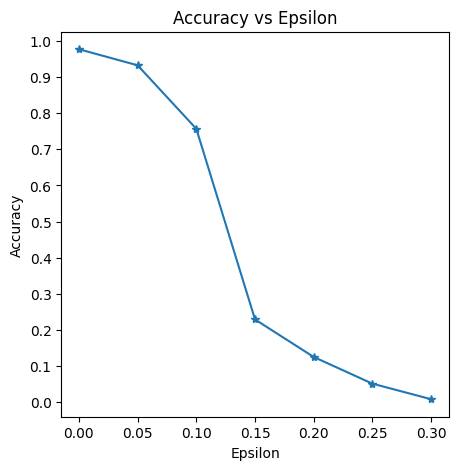

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
def lr_schedule(t):
    return 0.1 * 0.05 * (1 + np.cos(t / 20 * np.pi))

epsilon = 0.3

for epoch in range(20):
  model.train()

  opt = torch.optim.SGD(params = model.parameters(), lr=0.01)
  criterion = nn.CrossEntropyLoss()

  for X, y in train_loader:

    X = X.to(device)
    y = y.to(device)

    X_pert = pgd_attack(model, X, y, epsilon, epsilon/10*2.5, 10, 'l_inf', device)
    X_pert = X_pert.detach()
    robust_output = model(X_pert)

    robust_loss = criterion(robust_output, y)

    opt.zero_grad()
    robust_loss.backward()
    opt.step()

  model.eval()
  test_loss = 0
  test_acc = 0
  test_robust_loss = 0
  test_robust_acc = 0
  test_n = 0
  train_robust_loss = 0
  train_robust_acc = 0
  train_n = 0

  for X, y in train_loader:

    X = X.to(device)
    y = y.to(device)

    X_pert = pgd_attack(model, X, y, epsilon, epsilon/10*2.5, 10, 'l_inf', device)
    X_pert = X_pert.detach()
    robust_output = model(X_pert)
    robust_loss = criterion(robust_output, y)

    train_robust_loss += robust_loss.item() * y.size(0)
    train_robust_acc += (robust_output.max(1)[1] == y).sum().item()

    train_n += y.size(0)



  for X, y in test_loader:
      X = X.to(device)
      y = y.to(device)

      # Random initialization
      X_pert = pgd_attack(model, X, y, epsilon, epsilon/50*2.5, 50, 'l_inf', device)
      X_pert = X_pert.detach()

      robust_output = model(X_pert)
      robust_loss = criterion(robust_output, y)

      output = model(X)
      loss = criterion(output, y)

      test_robust_loss += robust_loss.item() * y.size(0)
      test_robust_acc += (robust_output.max(1)[1] == y).sum().item()
      test_loss += loss.item() * y.size(0)
      test_acc += (output.max(1)[1] == y).sum().item()
      test_n += y.size(0)

  print('test robust loss :', test_robust_loss/test_n, 'test robust acc :', test_robust_acc/test_n)

test robust loss : 2.14173281288147 test robust acc : 0.2778
